In [1]:
import sys

sys.path.append('/root/lib/')

import ROOT as r
import os
import json
import pandas as pd
import uproot 
import awkward as ak
import array as arr
import numpy as np
import shutil

sys.path.append(os.getcwd() + '/../utilities/')
from milliqanProcessor import *
from milliqanScheduler import *
from milliqanCuts import *
from milliqanPlotter import *

%jsroot on
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.30/02


In [11]:
def loadJson(jsonFile):
    fin = open(jsonFile)
    data = json.load(fin)
    lumis = pd.DataFrame(data['data'], columns=data['columns'])
    return lumis

goodRunsName = '/eos/experiment/milliqan/Configs/goodRunsList.json'
lumisName = '/eos/experiment/milliqan/Configs/mqLumis.json'
shutil.copy(goodRunsName, 'goodRunsList.json')
shutil.copy(lumisName, 'mqLumis.json')

goodRuns = loadJson('goodRunsList.json')
lumis = loadJson('mqLumis.json')

In [12]:
#get list of files to look at
files = []

beam = False

dataDir = '/store/user/milliqan/trees/v34/1500/'

for ifile, filename in enumerate(os.listdir(dataDir)):
    
    if not filename.endswith('root'): continue
    
    runNum = int(filename.split('Run')[1].split('.')[0])
    fileNum = int(filename.split('.')[1].split('_')[0])
        
    goodRun = goodRuns['goodRunTight'].loc[(goodRuns['run'] == runNum) & (goodRuns['file'] == fileNum)]
    beamOn = lumis['beam'].loc[(lumis['run'] == runNum) & (lumis['file'] == fileNum)]

    #if len(goodRun) == 0 or len(beamOn) == 0: continue #temporary
    if len(beamOn) == 0: continue

    #print(filename, runNum, fileNum, beamOn.item(), goodRun.item())
    
    if beam:
        #if goodRun.item() and beamOn.item(): files.append(dataDir+filename)
        if beamOn.item(): files.append(dataDir+filename)
    else:
        #if goodRun.item() and not beamOn.item(): files.append(dataDir+filename)
        if not beamOn.item(): files.append(dataDir+filename)


files, len(files)

(['/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.10_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.11_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.12_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.13_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.14_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.15_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.16_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.17_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.18_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.19_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.1_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.20_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.21_v34.root',
  '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.22_v34.root',
  '/store/user/milliq

In [25]:
def getRunFile(filename):
    run = filename.split('Run')[1].split('.')[0]
    file = filename.split('.')[1].split('_')[0]
    return [int(run), int(file)]


def getLumiofFileList(filelist):

    inputFiles = [getRunFile(x.split('/')[-1]) for x in filelist]

    mqLumis = shutil.copy('/eos/experiment/milliqan/Configs/mqLumis.json', 'mqLumis.json')
    lumis = pd.read_json('mqLumis.json', orient = 'split', compression = 'infer')

    lumis['start'] = pd.to_datetime(lumis['start'])
    lumis['stop'] = pd.to_datetime(lumis['stop'])

    myfiles = lumis[lumis.apply(lambda row: [int(row['run']), int(row['file'])] in inputFiles, axis=1)]

    totalLumi = myfiles['lumiEst'].sum()

    runTime = getRunTimes(myfiles)

    print("Running over {} files \n total of {} pb^-1 \n total run time {}s".format(len(filelist), totalLumi, runTime))

def getRunTimes(df):

    runTimes = df['stop'] - df['start']

    total_time = runTimes.sum()

    return total_time


In [5]:
'''def to_binary(x):
    return bin(int(x))[2:]

@mqCut
def triggerCut(self, cutName='triggerSelction', trigger=1, cut=False, branches=None):

    triggers = ak.firsts(self.events['tTrigger'])
    binary_trig = to_binary(trigger)

    # Apply the conversion function to each element in the Awkward Array
    triggers = ak.Array([to_binary(i) if i is not None else None for i in triggers])
    selection = triggers == binary_trig

    selection, _ = ak.broadcast_arrays(selection, self.events['tTrigger'])
    self.events[cutName] = selection

    if cut:
        for branch in branches:
            self.events[branch] = self.events[branch][selection]

    #print(binary_trig, triggers, selection)'''

"def to_binary(x):\n    return bin(int(x))[2:]\n\n@mqCut\ndef triggerCut(self, cutName='triggerSelction', trigger=1, cut=False, branches=None):\n\n    triggers = ak.firsts(self.events['tTrigger'])\n    binary_trig = to_binary(trigger)\n\n    # Apply the conversion function to each element in the Awkward Array\n    triggers = ak.Array([to_binary(i) if i is not None else None for i in triggers])\n    selection = triggers == binary_trig\n\n    selection, _ = ak.broadcast_arrays(selection, self.events['tTrigger'])\n    self.events[cutName] = selection\n\n    if cut:\n        for branch in branches:\n            self.events[branch] = self.events[branch][selection]\n\n    #print(binary_trig, triggers, selection)"

In [6]:
'''@mqCut
def threeInLine(self):
        areaCut = 0
        path = 1
        freeLayer = 3

        row = path//4
        col = path%4

        outputName = 'threeHitPath{}'.format(path)

        print("Checking three in line for path {}, row {}, col {}, with area cut {}".format(path, row, col, areaCut))

        layer0 = (self.events.layer0) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)
        layer1 = (self.events.layer1) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)
        layer2 = (self.events.layer2) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)
        layer3 = (self.events.layer3) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)

        threeStraight = ak.any(layer0, axis=1) & ak.any(layer1, axis=1) & ak.any(layer2, axis=1)
        self.events[outputName] = threeStraight
        self.events[outputName+'fourthLayer'] = (threeStraight) & (self.events.layer3) & (self.events.nPE >= areaCut)'''

'@mqCut\ndef threeInLine(self):\n        areaCut = 0\n        path = 1\n        freeLayer = 3\n\n        row = path//4\n        col = path%4\n\n        outputName = \'threeHitPath{}\'.format(path)\n\n        print("Checking three in line for path {}, row {}, col {}, with area cut {}".format(path, row, col, areaCut))\n\n        layer0 = (self.events.layer0) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)\n        layer1 = (self.events.layer1) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)\n        layer2 = (self.events.layer2) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)\n        layer3 = (self.events.layer3) & (self.events.nPE >= areaCut) & (self.events.row == row) & (self.events.column == col)\n\n        threeStraight = ak.any(layer0, axis=1) & ak.any(layer1, axis=1) & ak.any(layer2, axis=1)\n        self.events[outputName] = threeStraight\n        self.events[ou

In [19]:
@mqCut
def threeInLine(self):
        npeCut = 100

        for path in range(16):

            row = path//4
            col = path%4

            outputName = 'threeHitPath{}'.format(path)

            #print("Checking three in line for path {}, row {}, col {}, with area cut {}".format(path, row, col, areaCut))

            layer0 = (self.events.layer0) & (self.events.nPE >= npeCut) & (self.events.row == row) & (self.events.column == col)
            layer1 = (self.events.layer1) & (self.events.nPE >= npeCut) & (self.events.row == row) & (self.events.column == col)
            layer2 = (self.events.layer2) & (self.events.nPE >= npeCut) & (self.events.row == row) & (self.events.column == col)
            layer3 = (self.events.layer3) & (self.events.nPE >= npeCut) & (self.events.row == row) & (self.events.column == col)

            threeStraight_f0 = ak.any(layer1, axis=1) & ak.any(layer2, axis=1) & ak.any(layer3, axis=1)
            threeStraight_f1 = ak.any(layer0, axis=1) & ak.any(layer2, axis=1) & ak.any(layer3, axis=1)
            threeStraight_f2 = ak.any(layer0, axis=1) & ak.any(layer1, axis=1) & ak.any(layer3, axis=1)
            threeStraight_f3 = ak.any(layer0, axis=1) & ak.any(layer1, axis=1) & ak.any(layer2, axis=1)

            self.events[outputName+'_f0'] = threeStraight_f0
            self.events[outputName+'_f1'] = threeStraight_f1
            self.events[outputName+'_f2'] = threeStraight_f2
            self.events[outputName+'_f3'] = threeStraight_f3

            self.events[outputName+'_s0'] = (threeStraight_f0) & (self.events.layer0) & (self.events.nPE >= npeCut)
            self.events[outputName+'_s1'] = (threeStraight_f1) & (self.events.layer1) & (self.events.nPE >= npeCut)
            self.events[outputName+'_s2'] = (threeStraight_f2) & (self.events.layer2) & (self.events.nPE >= npeCut)
            self.events[outputName+'_s3'] = (threeStraight_f3) & (self.events.layer3) & (self.events.nPE >= npeCut)
            

In [8]:
@mqCut
def firstPulseCut(self, cutName='firstPulse', cut=False, branches=None):

    self.events[cutName] = self.events.ipulse == 0

    if cut:
        for branch in branches:
            self.events[branch] = self.events[branch][self.events[cutName]]

In [27]:
#define a file list to run over
filelist = files[:10]
print("Running on files {}".format(filelist))

#find the luminosity of files in filelist
getLumiofFileList(filelist)

#define the necessary branches to run over
branches = ['event', 'tTrigger', 'boardsMatched', 'pickupFlag', 'fileNumber', 'runNumber', 'type', 'ipulse', 'nPE',
            'time_module_calibrated', 'timeFit_module_calibrated', 'row', 'column', 'layer', 'height', 'area']

#define the milliqan cuts object
mycuts = milliqanCuts()

#require pulses are not pickup
pickupCut = mycuts.getCut(mycuts.pickupCut, 'pickupCut', cut=True, branches=branches)

#require that all digitizer boards are matched
boardMatchCut = mycuts.getCut(mycuts.boardsMatched, 'boardMatchCut', cut=True, branches=branches)

#require pulses to be near trigger window
pulseTime = mycuts.getCut(mycuts.centralTime, 'centralTimeCut', cut=True, branches=branches)

#height cut to get large pulses
muonHeightCut = mycuts.getCut(mycuts.heightCut, 'muonHeightCut', heightCut=1200, cut=True, branches=branches)

#muon area cut
muonAreaCut = getCutMod(mycuts.areaCut, mycuts, 'muonAreaCut', areaCut=0, cut=True, branches=branches)

#bar only cut
barCut = getCutMod(mycuts.barCut, mycuts, 'barCut', cut=True, branches=branches)

#define milliqan plotter
myplotter = milliqanPlotter()
myplotter.dict.clear()

#create root histogram 
bins = 400
xmin = 1100
xmax = 1500

'''h_pulseTime03 = r.TH2F("h_pulseTime03", "Pulse Times Between Layer 0 and 3", bins, xmin, xmax, bins, xmin, xmax)
h_L0Times = r.TH1F('h_L0Times', "Pulse Times Layer 0", 400, 1100, 1500)
h_L3Times = r.TH1F('h_L3Times', "Pulse Times Layer 3", 400, 1100, 1500)
h_TimeDiff = r.TH1F('h_TimeDiff', "Difference in Layer 0 and 3 Times", 100, -50, 50)'''
h_height = r.TH1F('h_height', "Height of Passing Pulses", 650, 0, 1300)
h_area = r.TH1F('h_area', "Area of Passing Pulses", 1000, 0, 100e4)
h_layer = r.TH1F('h_layer', 'Layer of Passing Pulses', 4, 0, 4)
h_fourLayer = r.TH1F('h_fourLayer', 'Layer of Passing Pulses in Events with 4 Layers', 4, 0, 4)

h_triggers = r.TH1F('h_triggers', 'Triggers of Passing Events', 16, 0, 16)
h_row = r.TH1F('h_row', 'Row of Passing Pulses', 4, 0, 4)
h_column = r.TH1F('h_column', 'Column of Passing Pulses', 4, 0, 4)
h_posL0 = r.TH2F('h_posL0', 'Row/Col of Passing Pulses in Layer 0', 4, 0, 4, 4, 0, 4)
h_posL1 = r.TH2F('h_posL1', 'Row/Col of Passing Pulses in Layer 1', 4, 0, 4, 4, 0, 4)
h_posL2 = r.TH2F('h_posL2', 'Row/Col of Passing Pulses in Layer 2', 4, 0, 4, 4, 0, 4)
h_posL3 = r.TH2F('h_posL3', 'Row/Col of Passing Pulses in Layer 3', 4, 0, 4, 4, 0, 4)

h_threeInLinePath0_f0 = r.TH2F('h_threeInLinePath0_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 0', 4, 0, 4, 4, 0, 4)
h_threeInLinePath1_f0 = r.TH2F('h_threeInLinePath1_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 1', 4, 0, 4, 4, 0, 4)
h_threeInLinePath2_f0 = r.TH2F('h_threeInLinePath2_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 2', 4, 0, 4, 4, 0, 4)
h_threeInLinePath3_f0 = r.TH2F('h_threeInLinePath3_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 3', 4, 0, 4, 4, 0, 4)
h_threeInLinePath4_f0 = r.TH2F('h_threeInLinePath4_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 4', 4, 0, 4, 4, 0, 4)
h_threeInLinePath5_f0 = r.TH2F('h_threeInLinePath5_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 5', 4, 0, 4, 4, 0, 4)
h_threeInLinePath6_f0 = r.TH2F('h_threeInLinePath6_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 6', 4, 0, 4, 4, 0, 4)
h_threeInLinePath7_f0 = r.TH2F('h_threeInLinePath7_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 7', 4, 0, 4, 4, 0, 4)
h_threeInLinePath8_f0 = r.TH2F('h_threeInLinePath8_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 8', 4, 0, 4, 4, 0, 4)
h_threeInLinePath9_f0 = r.TH2F('h_threeInLinePath9_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 9', 4, 0, 4, 4, 0, 4)
h_threeInLinePath10_f0 = r.TH2F('h_threeInLinePath10_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 10', 4, 0, 4, 4, 0, 4)
h_threeInLinePath11_f0 = r.TH2F('h_threeInLinePath11_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 11', 4, 0, 4, 4, 0, 4)
h_threeInLinePath12_f0 = r.TH2F('h_threeInLinePath12_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 12', 4, 0, 4, 4, 0, 4)
h_threeInLinePath13_f0 = r.TH2F('h_threeInLinePath13_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 13', 4, 0, 4, 4, 0, 4)
h_threeInLinePath14_f0 = r.TH2F('h_threeInLinePath14_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 14', 4, 0, 4, 4, 0, 4)
h_threeInLinePath15_f0 = r.TH2F('h_threeInLinePath15_f0', 'Row/Col of Layer 0 Pulse After 3 In Line Path 15', 4, 0, 4, 4, 0, 4)

h_threeInLinePath0_f1 = r.TH2F('h_threeInLinePath0_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 0', 4, 0, 4, 4, 0, 4)
h_threeInLinePath1_f1 = r.TH2F('h_threeInLinePath1_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 1', 4, 0, 4, 4, 0, 4)
h_threeInLinePath2_f1 = r.TH2F('h_threeInLinePath2_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 2', 4, 0, 4, 4, 0, 4)
h_threeInLinePath3_f1 = r.TH2F('h_threeInLinePath3_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 3', 4, 0, 4, 4, 0, 4)
h_threeInLinePath4_f1 = r.TH2F('h_threeInLinePath4_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 4', 4, 0, 4, 4, 0, 4)
h_threeInLinePath5_f1 = r.TH2F('h_threeInLinePath5_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 5', 4, 0, 4, 4, 0, 4)
h_threeInLinePath6_f1 = r.TH2F('h_threeInLinePath6_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 6', 4, 0, 4, 4, 0, 4)
h_threeInLinePath7_f1 = r.TH2F('h_threeInLinePath7_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 7', 4, 0, 4, 4, 0, 4)
h_threeInLinePath8_f1 = r.TH2F('h_threeInLinePath8_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 8', 4, 0, 4, 4, 0, 4)
h_threeInLinePath9_f1 = r.TH2F('h_threeInLinePath9_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 9', 4, 0, 4, 4, 0, 4)
h_threeInLinePath10_f1 = r.TH2F('h_threeInLinePath10_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 10', 4, 0, 4, 4, 0, 4)
h_threeInLinePath11_f1 = r.TH2F('h_threeInLinePath11_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 11', 4, 0, 4, 4, 0, 4)
h_threeInLinePath12_f1 = r.TH2F('h_threeInLinePath12_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 12', 4, 0, 4, 4, 0, 4)
h_threeInLinePath13_f1 = r.TH2F('h_threeInLinePath13_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 13', 4, 0, 4, 4, 0, 4)
h_threeInLinePath14_f1 = r.TH2F('h_threeInLinePath14_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 14', 4, 0, 4, 4, 0, 4)
h_threeInLinePath15_f1 = r.TH2F('h_threeInLinePath15_f1', 'Row/Col of Layer 1 Pulse After 3 In Line Path 15', 4, 0, 4, 4, 0, 4)

h_threeInLinePath0_f2 = r.TH2F('h_threeInLinePath0_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 1', 4, 0, 4, 4, 0, 4)
h_threeInLinePath1_f2 = r.TH2F('h_threeInLinePath1_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 2', 4, 0, 4, 4, 0, 4)
h_threeInLinePath2_f2 = r.TH2F('h_threeInLinePath2_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 3', 4, 0, 4, 4, 0, 4)
h_threeInLinePath3_f2 = r.TH2F('h_threeInLinePath3_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 4', 4, 0, 4, 4, 0, 4)
h_threeInLinePath4_f2 = r.TH2F('h_threeInLinePath4_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 5', 4, 0, 4, 4, 0, 4)
h_threeInLinePath5_f2 = r.TH2F('h_threeInLinePath5_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 6', 4, 0, 4, 4, 0, 4)
h_threeInLinePath6_f2 = r.TH2F('h_threeInLinePath6_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 7', 4, 0, 4, 4, 0, 4)
h_threeInLinePath7_f2 = r.TH2F('h_threeInLinePath7_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 8', 4, 0, 4, 4, 0, 4)
h_threeInLinePath8_f2 = r.TH2F('h_threeInLinePath8_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 9', 4, 0, 4, 4, 0, 4)
h_threeInLinePath9_f2 = r.TH2F('h_threeInLinePath9_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 10', 4, 0, 4, 4, 0, 4)
h_threeInLinePath10_f2 = r.TH2F('h_threeInLinePath10_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 11', 4, 0, 4, 4, 0, 4)
h_threeInLinePath11_f2 = r.TH2F('h_threeInLinePath11_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 12', 4, 0, 4, 4, 0, 4)
h_threeInLinePath12_f2 = r.TH2F('h_threeInLinePath12_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 13', 4, 0, 4, 4, 0, 4)
h_threeInLinePath13_f2 = r.TH2F('h_threeInLinePath13_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 14', 4, 0, 4, 4, 0, 4)
h_threeInLinePath14_f2 = r.TH2F('h_threeInLinePath14_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 15', 4, 0, 4, 4, 0, 4)
h_threeInLinePath15_f2 = r.TH2F('h_threeInLinePath15_f2', 'Row/Col of Layer 2 Pulse After 3 In Line Path 16', 4, 0, 4, 4, 0, 4)

h_threeInLinePath0_f3 = r.TH2F('h_threeInLinePath0_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 0', 4, 0, 4, 4, 0, 4)
h_threeInLinePath1_f3 = r.TH2F('h_threeInLinePath1_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 1', 4, 0, 4, 4, 0, 4)
h_threeInLinePath2_f3 = r.TH2F('h_threeInLinePath2_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 2', 4, 0, 4, 4, 0, 4)
h_threeInLinePath3_f3 = r.TH2F('h_threeInLinePath3_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 3', 4, 0, 4, 4, 0, 4)
h_threeInLinePath4_f3 = r.TH2F('h_threeInLinePath4_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 4', 4, 0, 4, 4, 0, 4)
h_threeInLinePath5_f3 = r.TH2F('h_threeInLinePath5_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 5', 4, 0, 4, 4, 0, 4)
h_threeInLinePath6_f3 = r.TH2F('h_threeInLinePath6_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 6', 4, 0, 4, 4, 0, 4)
h_threeInLinePath7_f3 = r.TH2F('h_threeInLinePath7_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 7', 4, 0, 4, 4, 0, 4)
h_threeInLinePath8_f3 = r.TH2F('h_threeInLinePath8_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 8', 4, 0, 4, 4, 0, 4)
h_threeInLinePath9_f3 = r.TH2F('h_threeInLinePath9_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 9', 4, 0, 4, 4, 0, 4)
h_threeInLinePath10_f3 = r.TH2F('h_threeInLinePath10_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 10', 4, 0, 4, 4, 0, 4)
h_threeInLinePath11_f3 = r.TH2F('h_threeInLinePath11_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 11', 4, 0, 4, 4, 0, 4)
h_threeInLinePath12_f3 = r.TH2F('h_threeInLinePath12_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 12', 4, 0, 4, 4, 0, 4)
h_threeInLinePath13_f3 = r.TH2F('h_threeInLinePath13_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 13', 4, 0, 4, 4, 0, 4)
h_threeInLinePath14_f3 = r.TH2F('h_threeInLinePath14_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 14', 4, 0, 4, 4, 0, 4)
h_threeInLinePath15_f3 = r.TH2F('h_threeInLinePath15_f3', 'Row/Col of Layer 3 Pulse After 3 In Line Path 15', 4, 0, 4, 4, 0, 4)


h_threeInLineCountPath0_f0 = r.TH1F('h_threeInLineCountPath0_f0', 'Events Passing Three In Line Path 0 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath1_f0 = r.TH1F('h_threeInLineCountPath1_f0', 'Events Passing Three In Line Path 1 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath2_f0 = r.TH1F('h_threeInLineCountPath2_f0', 'Events Passing Three In Line Path 2 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath3_f0 = r.TH1F('h_threeInLineCountPath3_f0', 'Events Passing Three In Line Path 3 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath4_f0 = r.TH1F('h_threeInLineCountPath4_f0', 'Events Passing Three In Line Path 4 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath5_f0 = r.TH1F('h_threeInLineCountPath5_f0', 'Events Passing Three In Line Path 5 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath6_f0 = r.TH1F('h_threeInLineCountPath6_f0', 'Events Passing Three In Line Path 6 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath7_f0 = r.TH1F('h_threeInLineCountPath7_f0', 'Events Passing Three In Line Path 7 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath8_f0 = r.TH1F('h_threeInLineCountPath8_f0', 'Events Passing Three In Line Path 8 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath9_f0 = r.TH1F('h_threeInLineCountPath9_f0', 'Events Passing Three In Line Path 9 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath10_f0 = r.TH1F('h_threeInLineCountPath10_f0', 'Events Passing Three In Line Path 10 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath11_f0 = r.TH1F('h_threeInLineCountPath11_f0', 'Events Passing Three In Line Path 11 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath12_f0 = r.TH1F('h_threeInLineCountPath12_f0', 'Events Passing Three In Line Path 12 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath13_f0 = r.TH1F('h_threeInLineCountPath13_f0', 'Events Passing Three In Line Path 13 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath14_f0 = r.TH1F('h_threeInLineCountPath14_f0', 'Events Passing Three In Line Path 14 Free Layer 0', 2, 0, 2)
h_threeInLineCountPath15_f0 = r.TH1F('h_threeInLineCountPath15_f0', 'Events Passing Three In Line Path 15 Free Layer 0', 2, 0, 2)

h_threeInLineCountPath0_f1 = r.TH1F('h_threeInLineCountPath0_f1', 'Events Passing Three In Line Path 0 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath1_f1 = r.TH1F('h_threeInLineCountPath1_f1', 'Events Passing Three In Line Path 1 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath2_f1 = r.TH1F('h_threeInLineCountPath2_f1', 'Events Passing Three In Line Path 2 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath3_f1 = r.TH1F('h_threeInLineCountPath3_f1', 'Events Passing Three In Line Path 3 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath4_f1 = r.TH1F('h_threeInLineCountPath4_f1', 'Events Passing Three In Line Path 4 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath5_f1 = r.TH1F('h_threeInLineCountPath5_f1', 'Events Passing Three In Line Path 5 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath6_f1 = r.TH1F('h_threeInLineCountPath6_f1', 'Events Passing Three In Line Path 6 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath7_f1 = r.TH1F('h_threeInLineCountPath7_f1', 'Events Passing Three In Line Path 7 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath8_f1 = r.TH1F('h_threeInLineCountPath8_f1', 'Events Passing Three In Line Path 8 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath9_f1 = r.TH1F('h_threeInLineCountPath9_f1', 'Events Passing Three In Line Path 9 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath10_f1 = r.TH1F('h_threeInLineCountPath10_f1', 'Events Passing Three In Line Path 10 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath11_f1 = r.TH1F('h_threeInLineCountPath11_f1', 'Events Passing Three In Line Path 11 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath12_f1 = r.TH1F('h_threeInLineCountPath12_f1', 'Events Passing Three In Line Path 12 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath13_f1 = r.TH1F('h_threeInLineCountPath13_f1', 'Events Passing Three In Line Path 13 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath14_f1 = r.TH1F('h_threeInLineCountPath14_f1', 'Events Passing Three In Line Path 14 Free Layer 1', 2, 0, 2)
h_threeInLineCountPath15_f1 = r.TH1F('h_threeInLineCountPath15_f1', 'Events Passing Three In Line Path 15 Free Layer 1', 2, 0, 2)

h_threeInLineCountPath0_f2 = r.TH1F('h_threeInLineCountPath0_f2', 'Events Passing Three In Line Path 0 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath1_f2 = r.TH1F('h_threeInLineCountPath1_f2', 'Events Passing Three In Line Path 1 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath2_f2 = r.TH1F('h_threeInLineCountPath2_f2', 'Events Passing Three In Line Path 2 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath3_f2 = r.TH1F('h_threeInLineCountPath3_f2', 'Events Passing Three In Line Path 3 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath4_f2 = r.TH1F('h_threeInLineCountPath4_f2', 'Events Passing Three In Line Path 4 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath5_f2 = r.TH1F('h_threeInLineCountPath5_f2', 'Events Passing Three In Line Path 5 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath6_f2 = r.TH1F('h_threeInLineCountPath6_f2', 'Events Passing Three In Line Path 6 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath7_f2 = r.TH1F('h_threeInLineCountPath7_f2', 'Events Passing Three In Line Path 7 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath8_f2 = r.TH1F('h_threeInLineCountPath8_f2', 'Events Passing Three In Line Path 8 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath9_f2 = r.TH1F('h_threeInLineCountPath9_f2', 'Events Passing Three In Line Path 9 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath10_f2 = r.TH1F('h_threeInLineCountPath10_f2', 'Events Passing Three In Line Path 10 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath11_f2 = r.TH1F('h_threeInLineCountPath11_f2', 'Events Passing Three In Line Path 11 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath12_f2 = r.TH1F('h_threeInLineCountPath12_f2', 'Events Passing Three In Line Path 12 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath13_f2 = r.TH1F('h_threeInLineCountPath13_f2', 'Events Passing Three In Line Path 13 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath14_f2 = r.TH1F('h_threeInLineCountPath14_f2', 'Events Passing Three In Line Path 14 Free Layer 2', 2, 0, 2)
h_threeInLineCountPath15_f2 = r.TH1F('h_threeInLineCountPath15_f2', 'Events Passing Three In Line Path 15 Free Layer 2', 2, 0, 2)

h_threeInLineCountPath0_f3 = r.TH1F('h_threeInLineCountPath0_f3', 'Events Passing Three In Line Path 0 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath1_f3 = r.TH1F('h_threeInLineCountPath1_f3', 'Events Passing Three In Line Path 1 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath2_f3 = r.TH1F('h_threeInLineCountPath2_f3', 'Events Passing Three In Line Path 2 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath3_f3 = r.TH1F('h_threeInLineCountPath3_f3', 'Events Passing Three In Line Path 3 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath4_f3 = r.TH1F('h_threeInLineCountPath4_f3', 'Events Passing Three In Line Path 4 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath5_f3 = r.TH1F('h_threeInLineCountPath5_f3', 'Events Passing Three In Line Path 5 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath6_f3 = r.TH1F('h_threeInLineCountPath6_f3', 'Events Passing Three In Line Path 6 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath7_f3 = r.TH1F('h_threeInLineCountPath7_f3', 'Events Passing Three In Line Path 7 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath8_f3 = r.TH1F('h_threeInLineCountPath8_f3', 'Events Passing Three In Line Path 8 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath9_f3 = r.TH1F('h_threeInLineCountPath9_f3', 'Events Passing Three In Line Path 9 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath10_f3 = r.TH1F('h_threeInLineCountPath10_f3', 'Events Passing Three In Line Path 10 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath11_f3 = r.TH1F('h_threeInLineCountPath11_f3', 'Events Passing Three In Line Path 11 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath12_f3 = r.TH1F('h_threeInLineCountPath12_f3', 'Events Passing Three In Line Path 12 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath13_f3 = r.TH1F('h_threeInLineCountPath13_f3', 'Events Passing Three In Line Path 13 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath14_f3 = r.TH1F('h_threeInLineCountPath14_f3', 'Events Passing Three In Line Path 14 Free Layer 3', 2, 0, 2)
h_threeInLineCountPath15_f3 = r.TH1F('h_threeInLineCountPath15_f3', 'Events Passing Three In Line Path 15 Free Layer 3', 2, 0, 2)

'''setattr(milliqanCuts, "centralTime", centralTime)
setattr(milliqanCuts, "pulseTime", pulseTime)'''
#setattr(milliqanCuts, "triggerCut", triggerCut)
setattr(milliqanCuts, "threeInLine", threeInLine)
setattr(milliqanCuts, "firstPulseCut", firstPulseCut)

triggerCut1 = getCutMod(mycuts.triggerCut, mycuts, 'triggerCut1', cutName='triggerCut1', trigger=1, cut=False, branches=branches)
triggerCut2 = getCutMod(mycuts.triggerCut, mycuts, 'triggerCut2', cutName='triggerCut2', trigger=2, cut=True, branches=branches)


#first pulse only cut
firstPulse = getCutMod(mycuts.firstPulseCut, mycuts, 'firstPulseCut', cutName='firstPulseCut', cut=True, branches=branches)

#add root histogram to plotter
'''myplotter.addHistograms(h_pulseTime03, ['straightPathL0Time', 'straightPathL3Time'])
myplotter.addHistograms(h_L0Times, 'straightPathL0Time')
myplotter.addHistograms(h_L3Times, 'straightPathL3Time')
myplotter.addHistograms(h_TimeDiff, 'straightPathDiffL03')'''
myplotter.addHistograms(h_height, 'height')
myplotter.addHistograms(h_area, 'area')
myplotter.addHistograms(h_layer, 'layer')
#myplotter.addHistograms(h_triggers, 'triggerCut2')
myplotter.addHistograms(h_row, 'row')
myplotter.addHistograms(h_column, 'column')
myplotter.addHistograms(h_posL0, ['row', 'column'], 'layer0')
myplotter.addHistograms(h_posL1, ['row', 'column'], 'layer1')
myplotter.addHistograms(h_posL2, ['row', 'column'], 'layer2')
myplotter.addHistograms(h_posL3, ['row', 'column'], 'layer3')

myplotter.addHistograms(h_fourLayer, 'layer', 'fourLayerCut')

myplotter.addHistograms(h_threeInLinePath0_f0, ['row', 'column'], 'threeHitPath0_s0')
myplotter.addHistograms(h_threeInLinePath1_f0, ['row', 'column'], 'threeHitPath1_s0')
myplotter.addHistograms(h_threeInLinePath2_f0, ['row', 'column'], 'threeHitPath2_s0')
myplotter.addHistograms(h_threeInLinePath3_f0, ['row', 'column'], 'threeHitPath3_s0')
myplotter.addHistograms(h_threeInLinePath4_f0, ['row', 'column'], 'threeHitPath4_s0')
myplotter.addHistograms(h_threeInLinePath5_f0, ['row', 'column'], 'threeHitPath5_s0')
myplotter.addHistograms(h_threeInLinePath6_f0, ['row', 'column'], 'threeHitPath6_s0')
myplotter.addHistograms(h_threeInLinePath7_f0, ['row', 'column'], 'threeHitPath7_s0')
myplotter.addHistograms(h_threeInLinePath8_f0, ['row', 'column'], 'threeHitPath8_s0')
myplotter.addHistograms(h_threeInLinePath9_f0, ['row', 'column'], 'threeHitPath9_s0')
myplotter.addHistograms(h_threeInLinePath10_f0, ['row', 'column'], 'threeHitPath10_s0')
myplotter.addHistograms(h_threeInLinePath11_f0, ['row', 'column'], 'threeHitPath11_s0')
myplotter.addHistograms(h_threeInLinePath12_f0, ['row', 'column'], 'threeHitPath12_s0')
myplotter.addHistograms(h_threeInLinePath13_f0, ['row', 'column'], 'threeHitPath13_s0')
myplotter.addHistograms(h_threeInLinePath14_f0, ['row', 'column'], 'threeHitPath14_s0')
myplotter.addHistograms(h_threeInLinePath15_f0, ['row', 'column'], 'threeHitPath15_s0')

myplotter.addHistograms(h_threeInLinePath0_f1, ['row', 'column'], 'threeHitPath0_s1')
myplotter.addHistograms(h_threeInLinePath1_f1, ['row', 'column'], 'threeHitPath1_s1')
myplotter.addHistograms(h_threeInLinePath2_f1, ['row', 'column'], 'threeHitPath2_s1')
myplotter.addHistograms(h_threeInLinePath3_f1, ['row', 'column'], 'threeHitPath3_s1')
myplotter.addHistograms(h_threeInLinePath4_f1, ['row', 'column'], 'threeHitPath4_s1')
myplotter.addHistograms(h_threeInLinePath5_f1, ['row', 'column'], 'threeHitPath5_s1')
myplotter.addHistograms(h_threeInLinePath6_f1, ['row', 'column'], 'threeHitPath6_s1')
myplotter.addHistograms(h_threeInLinePath7_f1, ['row', 'column'], 'threeHitPath7_s1')
myplotter.addHistograms(h_threeInLinePath8_f1, ['row', 'column'], 'threeHitPath8_s1')
myplotter.addHistograms(h_threeInLinePath9_f1, ['row', 'column'], 'threeHitPath9_s1')
myplotter.addHistograms(h_threeInLinePath10_f1, ['row', 'column'], 'threeHitPath10_s1')
myplotter.addHistograms(h_threeInLinePath11_f1, ['row', 'column'], 'threeHitPath11_s1')
myplotter.addHistograms(h_threeInLinePath12_f1, ['row', 'column'], 'threeHitPath12_s1')
myplotter.addHistograms(h_threeInLinePath13_f1, ['row', 'column'], 'threeHitPath13_s1')
myplotter.addHistograms(h_threeInLinePath14_f1, ['row', 'column'], 'threeHitPath14_s1')
myplotter.addHistograms(h_threeInLinePath15_f1, ['row', 'column'], 'threeHitPath15_s1')

myplotter.addHistograms(h_threeInLinePath0_f2, ['row', 'column'], 'threeHitPath0_s2')
myplotter.addHistograms(h_threeInLinePath1_f2, ['row', 'column'], 'threeHitPath1_s2')
myplotter.addHistograms(h_threeInLinePath2_f2, ['row', 'column'], 'threeHitPath2_s2')
myplotter.addHistograms(h_threeInLinePath3_f2, ['row', 'column'], 'threeHitPath3_s2')
myplotter.addHistograms(h_threeInLinePath4_f2, ['row', 'column'], 'threeHitPath4_s2')
myplotter.addHistograms(h_threeInLinePath5_f2, ['row', 'column'], 'threeHitPath5_s2')
myplotter.addHistograms(h_threeInLinePath6_f2, ['row', 'column'], 'threeHitPath6_s2')
myplotter.addHistograms(h_threeInLinePath7_f2, ['row', 'column'], 'threeHitPath7_s2')
myplotter.addHistograms(h_threeInLinePath8_f2, ['row', 'column'], 'threeHitPath8_s2')
myplotter.addHistograms(h_threeInLinePath9_f2, ['row', 'column'], 'threeHitPath9_s2')
myplotter.addHistograms(h_threeInLinePath10_f2, ['row', 'column'], 'threeHitPath10_s2')
myplotter.addHistograms(h_threeInLinePath11_f2, ['row', 'column'], 'threeHitPath11_s2')
myplotter.addHistograms(h_threeInLinePath12_f2, ['row', 'column'], 'threeHitPath12_s2')
myplotter.addHistograms(h_threeInLinePath13_f2, ['row', 'column'], 'threeHitPath13_s2')
myplotter.addHistograms(h_threeInLinePath14_f2, ['row', 'column'], 'threeHitPath14_s2')
myplotter.addHistograms(h_threeInLinePath15_f2, ['row', 'column'], 'threeHitPath15_s2')

myplotter.addHistograms(h_threeInLinePath0_f3, ['row', 'column'], 'threeHitPath0_s3')
myplotter.addHistograms(h_threeInLinePath1_f3, ['row', 'column'], 'threeHitPath1_s3')
myplotter.addHistograms(h_threeInLinePath2_f3, ['row', 'column'], 'threeHitPath2_s3')
myplotter.addHistograms(h_threeInLinePath3_f3, ['row', 'column'], 'threeHitPath3_s3')
myplotter.addHistograms(h_threeInLinePath4_f3, ['row', 'column'], 'threeHitPath4_s3')
myplotter.addHistograms(h_threeInLinePath5_f3, ['row', 'column'], 'threeHitPath5_s3')
myplotter.addHistograms(h_threeInLinePath6_f3, ['row', 'column'], 'threeHitPath6_s3')
myplotter.addHistograms(h_threeInLinePath7_f3, ['row', 'column'], 'threeHitPath7_s3')
myplotter.addHistograms(h_threeInLinePath8_f3, ['row', 'column'], 'threeHitPath8_s3')
myplotter.addHistograms(h_threeInLinePath9_f3, ['row', 'column'], 'threeHitPath9_s3')
myplotter.addHistograms(h_threeInLinePath10_f3, ['row', 'column'], 'threeHitPath10_s3')
myplotter.addHistograms(h_threeInLinePath11_f3, ['row', 'column'], 'threeHitPath11_s3')
myplotter.addHistograms(h_threeInLinePath12_f3, ['row', 'column'], 'threeHitPath12_s3')
myplotter.addHistograms(h_threeInLinePath13_f3, ['row', 'column'], 'threeHitPath13_s3')
myplotter.addHistograms(h_threeInLinePath14_f3, ['row', 'column'], 'threeHitPath14_s3')
myplotter.addHistograms(h_threeInLinePath15_f3, ['row', 'column'], 'threeHitPath15_s3')

myplotter.addHistograms(h_threeInLineCountPath0_f0, 'threeHitPath0_f0')
myplotter.addHistograms(h_threeInLineCountPath1_f0, 'threeHitPath1_f0')
myplotter.addHistograms(h_threeInLineCountPath2_f0, 'threeHitPath2_f0')
myplotter.addHistograms(h_threeInLineCountPath3_f0, 'threeHitPath3_f0')
myplotter.addHistograms(h_threeInLineCountPath4_f0, 'threeHitPath4_f0')
myplotter.addHistograms(h_threeInLineCountPath5_f0, 'threeHitPath5_f0')
myplotter.addHistograms(h_threeInLineCountPath6_f0, 'threeHitPath6_f0')
myplotter.addHistograms(h_threeInLineCountPath7_f0, 'threeHitPath7_f0')
myplotter.addHistograms(h_threeInLineCountPath8_f0, 'threeHitPath8_f0')
myplotter.addHistograms(h_threeInLineCountPath9_f0, 'threeHitPath9_f0')
myplotter.addHistograms(h_threeInLineCountPath10_f0, 'threeHitPath10_f0')
myplotter.addHistograms(h_threeInLineCountPath11_f0, 'threeHitPath11_f0')
myplotter.addHistograms(h_threeInLineCountPath12_f0, 'threeHitPath12_f0')
myplotter.addHistograms(h_threeInLineCountPath13_f0, 'threeHitPath13_f0')
myplotter.addHistograms(h_threeInLineCountPath14_f0, 'threeHitPath14_f0')
myplotter.addHistograms(h_threeInLineCountPath15_f0, 'threeHitPath15_f0')

myplotter.addHistograms(h_threeInLineCountPath0_f1, 'threeHitPath0_f1')
myplotter.addHistograms(h_threeInLineCountPath1_f1, 'threeHitPath1_f1')
myplotter.addHistograms(h_threeInLineCountPath2_f1, 'threeHitPath2_f1')
myplotter.addHistograms(h_threeInLineCountPath3_f1, 'threeHitPath3_f1')
myplotter.addHistograms(h_threeInLineCountPath4_f1, 'threeHitPath4_f1')
myplotter.addHistograms(h_threeInLineCountPath5_f1, 'threeHitPath5_f1')
myplotter.addHistograms(h_threeInLineCountPath6_f1, 'threeHitPath6_f1')
myplotter.addHistograms(h_threeInLineCountPath7_f1, 'threeHitPath7_f1')
myplotter.addHistograms(h_threeInLineCountPath8_f1, 'threeHitPath8_f1')
myplotter.addHistograms(h_threeInLineCountPath9_f1, 'threeHitPath9_f1')
myplotter.addHistograms(h_threeInLineCountPath10_f1, 'threeHitPath10_f1')
myplotter.addHistograms(h_threeInLineCountPath11_f1, 'threeHitPath11_f1')
myplotter.addHistograms(h_threeInLineCountPath12_f1, 'threeHitPath12_f1')
myplotter.addHistograms(h_threeInLineCountPath13_f1, 'threeHitPath13_f1')
myplotter.addHistograms(h_threeInLineCountPath14_f1, 'threeHitPath14_f1')
myplotter.addHistograms(h_threeInLineCountPath15_f1, 'threeHitPath15_f1')

myplotter.addHistograms(h_threeInLineCountPath0_f2, 'threeHitPath0_f2')
myplotter.addHistograms(h_threeInLineCountPath1_f2, 'threeHitPath1_f2')
myplotter.addHistograms(h_threeInLineCountPath2_f2, 'threeHitPath2_f2')
myplotter.addHistograms(h_threeInLineCountPath3_f2, 'threeHitPath3_f2')
myplotter.addHistograms(h_threeInLineCountPath4_f2, 'threeHitPath4_f2')
myplotter.addHistograms(h_threeInLineCountPath5_f2, 'threeHitPath5_f2')
myplotter.addHistograms(h_threeInLineCountPath6_f2, 'threeHitPath6_f2')
myplotter.addHistograms(h_threeInLineCountPath7_f2, 'threeHitPath7_f2')
myplotter.addHistograms(h_threeInLineCountPath8_f2, 'threeHitPath8_f2')
myplotter.addHistograms(h_threeInLineCountPath9_f2, 'threeHitPath9_f2')
myplotter.addHistograms(h_threeInLineCountPath10_f2, 'threeHitPath10_f2')
myplotter.addHistograms(h_threeInLineCountPath11_f2, 'threeHitPath11_f2')
myplotter.addHistograms(h_threeInLineCountPath12_f2, 'threeHitPath12_f2')
myplotter.addHistograms(h_threeInLineCountPath13_f2, 'threeHitPath13_f2')
myplotter.addHistograms(h_threeInLineCountPath14_f2, 'threeHitPath14_f2')
myplotter.addHistograms(h_threeInLineCountPath15_f2, 'threeHitPath15_f2')

myplotter.addHistograms(h_threeInLineCountPath0_f3, 'threeHitPath0_f3')
myplotter.addHistograms(h_threeInLineCountPath1_f3, 'threeHitPath1_f3')
myplotter.addHistograms(h_threeInLineCountPath2_f3, 'threeHitPath2_f3')
myplotter.addHistograms(h_threeInLineCountPath3_f3, 'threeHitPath3_f3')
myplotter.addHistograms(h_threeInLineCountPath4_f3, 'threeHitPath4_f3')
myplotter.addHistograms(h_threeInLineCountPath5_f3, 'threeHitPath5_f3')
myplotter.addHistograms(h_threeInLineCountPath6_f3, 'threeHitPath6_f3')
myplotter.addHistograms(h_threeInLineCountPath7_f3, 'threeHitPath7_f3')
myplotter.addHistograms(h_threeInLineCountPath8_f3, 'threeHitPath8_f3')
myplotter.addHistograms(h_threeInLineCountPath9_f3, 'threeHitPath9_f3')
myplotter.addHistograms(h_threeInLineCountPath10_f3, 'threeHitPath10_f3')
myplotter.addHistograms(h_threeInLineCountPath11_f3, 'threeHitPath11_f3')
myplotter.addHistograms(h_threeInLineCountPath12_f3, 'threeHitPath12_f3')
myplotter.addHistograms(h_threeInLineCountPath13_f3, 'threeHitPath13_f3')
myplotter.addHistograms(h_threeInLineCountPath14_f3, 'threeHitPath14_f3')
myplotter.addHistograms(h_threeInLineCountPath15_f3, 'threeHitPath15_f3')

#defining the cutflow
#cutflow = [boardMatchCut, pickupCut, 
'''cutflow = [boardMatchCut, pickupCut, triggerCut2, pulseTime, muonAreaCut, mycuts.layerCut,
            myplotter.dict['h_height'], myplotter.dict['h_area'], myplotter.dict['h_layer'], myplotter.dict['h_triggers']]'''

cutflow = [mycuts.totalEventCounter, boardMatchCut, pickupCut, barCut, pulseTime, firstPulse, mycuts.layerCut, mycuts.threeInLine, mycuts.fourLayerCut,
            myplotter.dict['h_height'], myplotter.dict['h_area'], myplotter.dict['h_layer'], myplotter.dict['h_fourLayer'],
            myplotter.dict['h_row'], myplotter.dict['h_column'], 
            myplotter.dict['h_posL0'], myplotter.dict['h_posL1'], myplotter.dict['h_posL2'], myplotter.dict['h_posL3']]

for key, value in myplotter.dict.items():
    if value not in cutflow:
        cutflow.append(value)

#create a schedule of the cuts
myschedule = milliQanScheduler(cutflow, mycuts, myplotter)

#print out the schedule
myschedule.printSchedule()

#create the milliqan processor object
myiterator = milliqanProcessor(filelist, branches, myschedule, step_size=10000)

#run the milliqan processor
myiterator.run()

#save plots
myplotter.saveHistograms("test.root")

mycuts.getCutflowCounts()

Running on files ['/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.10_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.11_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.12_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.13_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.14_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.15_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.16_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.17_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.18_v34.root', '/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.19_v34.root']
Running over 10 files 
 total of 0.0 pb^-1 
 total run time 0 days 01:20:08s
----------------------------
MilliQan Scheduler:
	0. totalEventCounter
	1. boardMatchCut
	2. pickupCut
	3. barCut
	4. centralTimeCut
	5. firstPulseCut
	6. layerCut
	7. threeInLine
	8. fourLayerCut
	9. h_height
	10. h_area
	11

KeyError: 'fileNumber'

Warning in <TROOT::Append>: Replacing existing TH1: h_height (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_area (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_layer (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_fourLayer (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_triggers (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_row (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_column (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_posL0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_posL1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_posL2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_posL3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_three

In [221]:
#clear old plots
for key, value in myplotter.dict.items():
    print(key, value)
    del key


h_height <milliqanPlotter.milliqanPlot object at 0x7f9845387b20>
h_area <milliqanPlotter.milliqanPlot object at 0x7f9842fa1400>
h_layer <milliqanPlotter.milliqanPlot object at 0x7f9845387850>
h_row <milliqanPlotter.milliqanPlot object at 0x7f9845387ca0>
h_column <milliqanPlotter.milliqanPlot object at 0x7f9845387970>
h_posL0 <milliqanPlotter.milliqanPlot object at 0x7f9845387fa0>
h_posL1 <milliqanPlotter.milliqanPlot object at 0x7f9845387d30>
h_posL2 <milliqanPlotter.milliqanPlot object at 0x7f9845387c40>
h_posL3 <milliqanPlotter.milliqanPlot object at 0x7f984489aa60>
h_fourLayer <milliqanPlotter.milliqanPlot object at 0x7f984489aa00>
h_threeInLinePath0_f0 <milliqanPlotter.milliqanPlot object at 0x7f9845a1b220>
h_threeInLinePath1_f0 <milliqanPlotter.milliqanPlot object at 0x7f9845a1bf70>
h_threeInLinePath2_f0 <milliqanPlotter.milliqanPlot object at 0x7f984d9408e0>
h_threeInLinePath3_f0 <milliqanPlotter.milliqanPlot object at 0x7f98459609d0>
h_threeInLinePath4_f0 <milliqanPlotter.milliq

In [11]:
c1 = r.TCanvas("c1", "c1", 600, 600)

In [ ]:
h_layer.Draw()
c1.Draw()

In [ ]:
h_posL0.Draw('colz')
c1.Draw()

In [2]:
myplotter.dict

NameError: name 'myplotter' is not defined

In [ ]:
h_row.Draw()
c1.Draw()

In [ ]:
h_column.Draw()
c1.Draw()

In [ ]:
filelist

In [37]:
myfile = r.TFile.Open('/store/user/milliqan/trees/v34/1500/MilliQan_Run1500.10_v34.root')

mytree = myfile.Get('t')


In [38]:
c1.cd()
print(mytree.GetEntries())
mytree.Draw('event', 'MaxIf$(height, !pickupFlag)')
c1.Draw()

1000


In [49]:
mytree.Scan('event:Length$(height):tTrigger', '')


1000

************************************************
*    Row   *     event * Length$(h *  tTrigger *
************************************************
*        0 *         0 *         8 *        16 *
*        1 *         1 *        16 *         2 *
*        2 *         2 *         6 *        64 *
*        3 *         3 *        20 *         2 *
*        4 *         4 *         1 *       256 *
*        5 *         5 *         7 *         2 *
*        6 *         6 *        14 *         2 *
*        7 *         7 *         9 *       512 *
*        8 *         8 *        12 *         2 *
*        9 *         9 *         9 *        16 *
*       10 *        10 *        13 *       512 *
*       11 *        11 *        11 *        64 *
*       12 *        12 *         6 *       512 *
*       13 *        13 *         1 *      4096 *
*       14 *        14 *         9 *        16 *
*       15 *        15 *         4 *        64 *
*       16 *        16 *        30 *         2 *
*       17 *        

Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> Type <CR> to continue or 

In [170]:
#open the root output file and calculate the rate that channels fire

#fin = r.TFile.Open('bgAnalysis_1500_noBeamInFill.root', 'read')
fin = r.TFile.Open('bgAnalysis_1300_noBeamInFill.root', 'read')

tag = '1300_noBeamInFill'

In [171]:
fin.ls()

TFile**		bgAnalysis_1300_noBeamInFill.root	
 TFile*		bgAnalysis_1300_noBeamInFill.root	
  KEY: TH1F	h_height;1	Height of Passing Pulses
  KEY: TH1F	h_area;1	Area of Passing Pulses
  KEY: TH1F	h_layer;1	Layer of Passing Pulses
  KEY: TH1F	h_row;1	Row of Passing Pulses
  KEY: TH1F	h_column;1	Column of Passing Pulses
  KEY: TH2F	h_posL0;1	Row/Col of Passing Pulses in Layer 0
  KEY: TH2F	h_posL1;1	Row/Col of Passing Pulses in Layer 1
  KEY: TH2F	h_posL2;1	Row/Col of Passing Pulses in Layer 2
  KEY: TH2F	h_posL3;1	Row/Col of Passing Pulses in Layer 3
  KEY: TH1F	h_fourLayer;1	Layer of Passing Pulses in Events with 4 Layers
  KEY: TH2F	h_threeInLinePath0_f0;1	Row/Col of Layer 0 Pulse After 3 In Line Path 0
  KEY: TH2F	h_threeInLinePath1_f0;1	Row/Col of Layer 0 Pulse After 3 In Line Path 1
  KEY: TH2F	h_threeInLinePath2_f0;1	Row/Col of Layer 0 Pulse After 3 In Line Path 2
  KEY: TH2F	h_threeInLinePath3_f0;1	Row/Col of Layer 0 Pulse After 3 In Line Path 3
  KEY: TH2F	h_threeInLinePath4_f0;1	Ro

In [172]:
#next steps
#get counts of how often each 3 in line path occurs
#get 4th layer counts for each channel of each 4th layer path

import math

countHistograms = []
pathHistograms = []

for key in fin.GetListOfKeys():
    print(key.GetName())
    if key.GetName().startswith('h_threeInLineCountPath'): countHistograms.append(key.ReadObj())
    if key.GetName().startswith('h_threeInLinePath'): pathHistograms.append(key.ReadObj())

h_height
h_area
h_layer
h_row
h_column
h_posL0
h_posL1
h_posL2
h_posL3
h_fourLayer
h_threeInLinePath0_f0
h_threeInLinePath1_f0
h_threeInLinePath2_f0
h_threeInLinePath3_f0
h_threeInLinePath4_f0
h_threeInLinePath5_f0
h_threeInLinePath6_f0
h_threeInLinePath7_f0
h_threeInLinePath8_f0
h_threeInLinePath9_f0
h_threeInLinePath10_f0
h_threeInLinePath11_f0
h_threeInLinePath12_f0
h_threeInLinePath13_f0
h_threeInLinePath14_f0
h_threeInLinePath15_f0
h_threeInLinePath0_f1
h_threeInLinePath1_f1
h_threeInLinePath2_f1
h_threeInLinePath3_f1
h_threeInLinePath4_f1
h_threeInLinePath5_f1
h_threeInLinePath6_f1
h_threeInLinePath7_f1
h_threeInLinePath8_f1
h_threeInLinePath9_f1
h_threeInLinePath10_f1
h_threeInLinePath11_f1
h_threeInLinePath12_f1
h_threeInLinePath13_f1
h_threeInLinePath14_f1
h_threeInLinePath15_f1
h_threeInLinePath0_f2
h_threeInLinePath1_f2
h_threeInLinePath2_f2
h_threeInLinePath3_f2
h_threeInLinePath4_f2
h_threeInLinePath5_f2
h_threeInLinePath6_f2
h_threeInLinePath7_f2
h_threeInLinePath8_f2
h_t

In [173]:
counts = []

for hist in countHistograms:
    failed = hist.GetBinContent(1)
    passing = hist.GetBinContent(2)
    counts.append([failed, passing])

In [174]:
#plot the ratio of events with each 3 in line trigger

h_ratio3InLine_L0 = r.TH1F('h_ratio3InLine_L0', "Ratio of Events with 3 In Line Triggers (Layer 0 Free)", 16, 0, 16)
h_ratio3InLine_L1 = r.TH1F('h_ratio3InLine_L1', "Ratio of Events with 3 In Line Triggers (Layer 1 Free)", 16, 0, 16)
h_ratio3InLine_L2 = r.TH1F('h_ratio3InLine_L2', "Ratio of Events with 3 In Line Triggers (Layer 2 Free)", 16, 0, 16)
h_ratio3InLine_L3 = r.TH1F('h_ratio3InLine_L3', "Ratio of Events with 3 In Line Triggers (Layer 3 Free)", 16, 0, 16)

h_counts3InLine_L0 = r.TH1F('h_counts3InLine_L0', "Number of Events with 3 In Line Triggers (Layer 0 Free)", 16, 0, 16)
h_counts3InLine_L1 = r.TH1F('h_counts3InLine_L1', "Number of Events with 3 In Line Triggers (Layer 1 Free)", 16, 0, 16)
h_counts3InLine_L2 = r.TH1F('h_counts3InLine_L2', "Number of Events with 3 In Line Triggers (Layer 2 Free)", 16, 0, 16)
h_counts3InLine_L3 = r.TH1F('h_counts3InLine_L3', "Number of Events with 3 In Line Triggers (Layer 3 Free)", 16, 0, 16)

h_counts3InLine = [h_counts3InLine_L0, h_counts3InLine_L1, h_counts3InLine_L2, h_counts3InLine_L3]
h_ratio3InLine = [h_ratio3InLine_L0, h_ratio3InLine_L1, h_ratio3InLine_L2, h_ratio3InLine_L3]

for ic, count in enumerate(counts):
    ratio = count[1] / (count[0] + count[1])
    error = 0
    if count[0]+count[1] > 0: 
        if count[1] == 0: count[1] = 1
        error = ratio * math.sqrt((math.sqrt(count[1])/count[1]**2) + (math.sqrt(count[1]+count[0])/(count[0]+count[1]))**2)
    errorC = 1
    if count[1] > 0: errorC = math.sqrt(count[1])

    #print("Filling histo {} bin {} with ratio {}, error {}".format(ic//16, ic, ratio, error))
    h_ratio3InLine[ic//16].SetBinContent(ic%16+1, ratio)
    h_ratio3InLine[ic//16].SetBinError(ic%16+1, error)

    h_counts3InLine[ic//16].SetBinContent(ic%16+1, count[1])
    h_counts3InLine[ic//16].SetBinError(ic%16+1, errorC)



In [175]:
c2 = r.TCanvas("c2", "c2", 800, 800)
c2.Divide(1, 4)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


In [176]:
c2.cd(1)
h_ratio3InLine_L0.Draw("E")
c2.cd(2)
h_ratio3InLine_L1.Draw("E")
c2.cd(3)
h_ratio3InLine[2].Draw("E")
c2.cd(4)
h_ratio3InLine_L3.Draw("E")
c2.Draw()

In [177]:
c2.SaveAs("plots/RatioThreeInLine_{}.pdf".format(tag))

Info in <TCanvas::Print>: pdf file plots/RatioThreeInLine_1300_noBeamInFill.pdf has been created


In [178]:
c2.cd(1)
h_counts3InLine_L0.Draw("E")
c2.cd(2)
h_counts3InLine_L1.Draw("E")
c2.cd(3)
h_counts3InLine_L2.Draw("E")
c2.cd(4)
h_counts3InLine_L3.Draw("E")
c2.Draw()

In [179]:
c2.SaveAs("plots/CountsThreeInLine_{}.pdf".format(tag))

Info in <TCanvas::Print>: pdf file plots/CountsThreeInLine_1300_noBeamInFill.pdf has been created


In [180]:
#now get counts for each 4th layer channel

fourthLayerCounts = []

for i in range(64): #loop over plots
    total_counts = np.zeros((4, 4))
    #if i > 0: continue
    hist = pathHistograms[i]
    for row in range(4): #loop over rows
        for col in range(4): #loop over columns
            counts_ = hist.GetBinContent(row+1, col+1)
            total_counts[row][col] = counts_
    fourthLayerCounts.append(total_counts)

ratioFourthLayer = fourthLayerCounts.copy()
#find ratio of total events that had 3 in line
for i, (layer, total) in enumerate(zip(ratioFourthLayer, counts)):
    if not total[1] == 0: 
        ratioFourthLayer[i] = layer / total[1]

In [181]:
#draw all 4th layer plots

c3 = r.TCanvas("c3", "c3", 1000, 1000)
c3.Divide(4, 4)
c4 = r.TCanvas("c4", "c4", 1000, 1000)
c4.Divide(4, 4)
c5 = r.TCanvas("c5", "c5", 1000, 1000)
c5.Divide(4, 4)
c6 = r.TCanvas("c6", "c6", 1000, 1000)
c6.Divide(4, 4)

canvases = [c3, c4, c5, c6]

for i in range(64):
    canvases[i//16].cd(i%16+1)
    #c3.cd(i+1)
    pathHistograms[i].Draw('colz text')

    #titles were saved wrong, need to fix
    path = pathHistograms[i].GetName().split('Path')[1].split('_')[0]
    name = pathHistograms[i].GetTitle().split()[:-1]
    name = ' '.join(name)
    name += (' ' + path)
    pathHistograms[i].SetTitle(name)
    
    pathHistograms[i].GetXaxis().SetTitle("Row")
    pathHistograms[i].GetYaxis().SetTitle("Column")
    pathHistograms[i].SetStats(False)
#c3.Draw()

c3.SaveAs('plots/fourthLayerCounts_L0_{}.pdf'.format(tag))
c4.SaveAs('plots/fourthLayerCounts_L1_{}.pdf'.format(tag))
c5.SaveAs('plots/fourthLayerCounts_L2_{}.pdf'.format(tag))
c6.SaveAs('plots/fourthLayerCounts_L3_{}.pdf'.format(tag))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c6
Info in <TCanvas::Print>: pdf file plots/fourthLayerCounts_L0_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerCounts_L1_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerCounts_L2_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerCounts_L3_1300_noBeamInFill.pdf has been created


In [15]:
c3.Draw()

In [160]:
c4.Draw()

In [161]:
c5.Draw()

In [145]:
c6.Draw()

In [43]:
c3.SaveAs('plots/fourthLayerCounts_L0.pdf')

Info in <TCanvas::Print>: pdf file plots/fourthLayerCounts_L0.pdf has been created


In [182]:
#draw all 4th layer plot ratios

c3 = r.TCanvas("c3", "c3", 1000, 1000)
c3.Divide(4, 4)
c4 = r.TCanvas("c4", "c4", 1000, 1000)
c4.Divide(4, 4)
c5 = r.TCanvas("c5", "c5", 1000, 1000)
c5.Divide(4, 4)
c6 = r.TCanvas("c6", "c6", 1000, 1000)
c6.Divide(4, 4)

canvases = [c3, c4, c5, c6]

for i in range(64):
    canvases[i//16].cd(i%16+1)

    print("Total 3 In line paths", counts[i][1])

    if counts[i][1] > 0: pathHistograms[i].Scale(1/counts[i][1]) #scale by total number of 3 in line paths
    pathHistograms[i].Draw('colz text')

    #titles were saved wrong, need to fix
    path = pathHistograms[i].GetName().split('Path')[1].split('_')[0]
    name = pathHistograms[i].GetTitle().split()[:-1]
    name = ' '.join(name)
    name += (' ' + path)
    pathHistograms[i].SetTitle(name)
    
    pathHistograms[i].GetXaxis().SetTitle("Row")
    pathHistograms[i].GetYaxis().SetTitle("Column")
    pathHistograms[i].SetStats(False)
#c3.Draw()

c3.SaveAs('plots/fourthLayerRatios_L0_{}.pdf'.format(tag))
c4.SaveAs('plots/fourthLayerRatios_L1_{}.pdf'.format(tag))
c5.SaveAs('plots/fourthLayerRatios_L2_{}.pdf'.format(tag))
c6.SaveAs('plots/fourthLayerRatios_L3_{}.pdf'.format(tag))

Total 3 In line paths 29.0
Total 3 In line paths 26.0
Total 3 In line paths 17.0
Total 3 In line paths 14.0
Total 3 In line paths 1
Total 3 In line paths 1
Total 3 In line paths 14.0
Total 3 In line paths 12.0
Total 3 In line paths 81.0
Total 3 In line paths 50.0
Total 3 In line paths 33.0
Total 3 In line paths 20.0
Total 3 In line paths 113.0
Total 3 In line paths 72.0
Total 3 In line paths 72.0
Total 3 In line paths 83.0
Total 3 In line paths 11.0
Total 3 In line paths 3.0
Total 3 In line paths 4.0
Total 3 In line paths 4.0
Total 3 In line paths 2.0
Total 3 In line paths 11.0
Total 3 In line paths 4.0
Total 3 In line paths 4.0
Total 3 In line paths 18.0
Total 3 In line paths 13.0
Total 3 In line paths 6.0
Total 3 In line paths 9.0
Total 3 In line paths 38.0
Total 3 In line paths 21.0
Total 3 In line paths 17.0
Total 3 In line paths 26.0
Total 3 In line paths 10.0
Total 3 In line paths 2.0
Total 3 In line paths 9.0
Total 3 In line paths 3.0
Total 3 In line paths 1
Total 3 In line path

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c6
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios_L0_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios_L1_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios_L2_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios_L3_1300_noBeamInFill.pdf has been created


In [183]:
#draw all 4th layer plot ratios given hit in 4th layer

c3 = r.TCanvas("c3", "c3", 1000, 1000)
c3.Divide(4, 4)
c4 = r.TCanvas("c4", "c4", 1000, 1000)
c4.Divide(4, 4)
c5 = r.TCanvas("c5", "c5", 1000, 1000)
c5.Divide(4, 4)
c6 = r.TCanvas("c6", "c6", 1000, 1000)
c6.Divide(4, 4)

canvases = [c3, c4, c5, c6]

for i in range(64):
    canvases[i//16].cd(i%16+1)

    totalHits = np.sum(fourthLayerCounts[i])
    print("Sum of hits", totalHits)

    if totalHits > 0: pathHistograms[i].Scale(1/totalHits) #scale by total number of 3 in line paths
    pathHistograms[i].Draw('colz text')

    #titles were saved wrong, need to fix
    path = pathHistograms[i].GetName().split('Path')[1].split('_')[0]
    name = pathHistograms[i].GetTitle().split()[:-1]
    name = ' '.join(name)
    name += (' ' + path)
    pathHistograms[i].SetTitle(name)
    
    pathHistograms[i].GetXaxis().SetTitle("Row")
    pathHistograms[i].GetYaxis().SetTitle("Column")
    pathHistograms[i].SetStats(False)
#c3.Draw()

c3.SaveAs('plots/fourthLayerRatios4thHit_L0_{}.pdf'.format(tag))
c4.SaveAs('plots/fourthLayerRatios4thHit_L1_{}.pdf'.format(tag))
c5.SaveAs('plots/fourthLayerRatios4thHit_L2_{}.pdf'.format(tag))
c6.SaveAs('plots/fourthLayerRatios4thHit_L3_{}.pdf'.format(tag))

Sum of hits 34.0
Sum of hits 22.0
Sum of hits 9.0
Sum of hits 9.0
Sum of hits 0.0
Sum of hits 0.0
Sum of hits 16.0
Sum of hits 7.0
Sum of hits 171.0
Sum of hits 88.0
Sum of hits 54.0
Sum of hits 16.0
Sum of hits 244.0
Sum of hits 140.0
Sum of hits 114.0
Sum of hits 127.0
Sum of hits 13.0
Sum of hits 2.0
Sum of hits 7.0
Sum of hits 6.0
Sum of hits 0.0
Sum of hits 23.0
Sum of hits 3.0
Sum of hits 6.0
Sum of hits 84.0
Sum of hits 55.0
Sum of hits 18.0
Sum of hits 15.0
Sum of hits 188.0
Sum of hits 138.0
Sum of hits 70.0
Sum of hits 107.0
Sum of hits 19.0
Sum of hits 3.0
Sum of hits 12.0
Sum of hits 5.0
Sum of hits 0.0
Sum of hits 0.0
Sum of hits 13.0
Sum of hits 2.0
Sum of hits 96.0
Sum of hits 76.0
Sum of hits 10.0
Sum of hits 18.0
Sum of hits 245.0
Sum of hits 135.0
Sum of hits 102.0
Sum of hits 100.0
Sum of hits 62.0
Sum of hits 60.0
Sum of hits 53.0
Sum of hits 55.0
Sum of hits 0.0
Sum of hits 0.0
Sum of hits 27.0
Sum of hits 55.0
Sum of hits 69.0
Sum of hits 72.0
Sum of hits 53.0
Sum

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c6
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios4thHit_L0_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios4thHit_L1_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios4thHit_L2_1300_noBeamInFill.pdf has been created
Info in <TCanvas::Print>: pdf file plots/fourthLayerRatios4thHit_L3_1300_noBeamInFill.pdf has been created


In [184]:
#plot distance from straight line path

c1 = r.TCanvas("c1", "c1", 800, 600)

h_movementTotal = r.TH2F('h_movementTotal', 'Movement from Straight Line Path', 7, -3, 4, 7, -3, 4)
h_movementL0 = r.TH2F('h_movementL0', 'Movement from Straight Line Path L0 Free', 7, -3, 4, 7, -3, 4)
h_movementL1 = r.TH2F('h_movementL1', 'Movement from Straight Line Path L1 Free', 7, -3, 4, 7, -3, 4)
h_movementL2 = r.TH2F('h_movementL2', 'Movement from Straight Line Path L2 Free', 7, -3, 4, 7, -3, 4)
h_movementL3 = r.TH2F('h_movementL3', 'Movement from Straight Line Path L3 Free', 7, -3, 4, 7, -3, 4)
h_normalization = r.TH2F('h_normalization', 'Normalization Histogram', 7, -3, 4, 7, -3, 4)

h_movementAbsDistance = r.TH1F('h_movementAbsDistance', 'Distance from Straight Line Path', 28, 0, 7)
h_movementAbsSum = r.TH1F('h_movementAbsSum', 'Sum of Movement from Straight Line Path', 28, 0, 7)
h_movementAbsMax = r.TH1F('h_movementAbsMax', 'Max of Movement from Straight Line Path', 28, 0, 7)

h_normalizationAbsDistance = r.TH1F('h_normalizationAbsDistance', 'Normalization Histogram', 28, 0, 7)
h_normalizationAbsSum = r.TH1F('h_normalizationAbsSum', 'Normalization Histogram', 28, 0, 7)
h_normalizationAbsMax = r.TH1F('h_normalizationAbsMax', 'Normalization Histogram', 28, 0, 7)

layer_hists = [h_movementL0, h_movementL1, h_movementL2, h_movementL3]

for ipath, path in enumerate(fourthLayerCounts):
    #print(path)
    freelayer = ipath//16
    s_row = (ipath - freelayer*16)//4
    s_col = ipath%4
    for irow, row in enumerate(path):
        for icol, col in enumerate(row):
            deltaRow = s_row - irow
            deltaCol = s_col - icol

            value = 0
            totalHits = counts[ipath][1]
            if totalHits > 0:
                value = col / totalHits #counts[ipath][1]
            #print("path {}, totalHits {}, value {}, deltaRow {}".format(ipath, totalHits, value))
            if freelayer == 3 and deltaRow == -3 and deltaCol == 2: 
             print("Path {}, path row {}, this row {}, delta row {}, Path col {}, this col {}, delta col {}, totalHits {}, value {}".format(ipath, s_row, irow, deltaRow, s_col, icol, deltaCol, totalHits, value))
            h_movementTotal.Fill(deltaRow, deltaCol, value)
            h_normalization.Fill(deltaRow, deltaCol)

            movement = math.sqrt((abs(deltaCol)**2) + (abs(deltaRow)**2))
            h_movementAbsDistance.Fill(movement, value)
            h_normalizationAbsDistance.Fill(movement)

            h_movementAbsSum.Fill(deltaRow+deltaCol, value)
            h_normalizationAbsSum.Fill(deltaRow+deltaCol)

            max_d = max([deltaRow, deltaCol])
            h_movementAbsMax.Fill(max_d, value)
            h_normalizationAbsMax.Fill(max_d)

            layer_hists[freelayer].Fill(deltaRow, deltaCol, value)


h_movementTotal.Divide(h_normalization)
h_movementAbsDistance.Divide(h_normalizationAbsDistance)
h_movementAbsSum.Divide(h_normalizationAbsSum)
h_movementAbsMax.Divide(h_normalizationAbsMax)

h_normalization.Scale(1./4)
for h in layer_hists:
    h.Divide(h_normalization)

fout = r.TFile.Open('plots/backgroundPlotsRatio_{}.root'.format(tag), 'recreate')
fout.cd()
h_movementTotal.Write()
h_normalization.Write()
h_movementL0.Write()
h_movementL1.Write()
h_movementL2.Write()
h_movementL3.Write()
h_movementAbsDistance.Write()
h_normalizationAbsDistance.Write()
h_movementAbsSum.Write()
h_normalizationAbsSum.Write()
h_movementAbsMax.Write()
h_normalizationAbsMax.Write()
fout.Close()


Path 50, path row 0, this row 3, delta row -3, Path col 2, this col 0, delta col 2, totalHits 84.0, value 0.08333333333333333
Path 51, path row 0, this row 3, delta row -3, Path col 3, this col 1, delta col 2, totalHits 102.0, value 0.06862745098039216


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [87]:
print(fourthLayerCounts[0])
print(fourthLayerCounts[16])

[[3. 1. 1. 0.]
 [3. 2. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
[[3. 2. 1. 3.]
 [0. 0. 0. 2.]
 [1. 2. 1. 2.]
 [1. 2. 2. 0.]]


In [185]:
c1.cd()
h_movementTotal.Draw('colz text')
h_movementTotal.SetStats(False)
c1.Draw()

In [186]:
h_movementAbsDistance.Draw('hist')
c1.Draw()

In [73]:
h_normalizationAbs.Draw()
c1.Draw()

In [148]:
c1.cd()
h_ratio3InLine_L1.Draw()
c1.Draw()

In [248]:
lumis = pd.read_json('mqLumis.json', orient = 'split', compression = 'infer')

In [249]:
lumis[lumis['run']==1118]['lumiEst'].sum()

2136.269022395

In [63]:
goodRuns = pd.read_json('checksMerged.json', orient = 'split', compression = 'infer')

goodRuns.columns

Index(['run', 'file', 'rawDir', 'offlineDir', 'daqFile', 'trigFile',
       'matchFile', 'offlineFile', 'totalEvents', 'unmatchedEvents',
       'startTime', 'unmatchedBoards', 'daqCTime', 'trigCTime', 'matchCTime',
       'offlineCTime', 'offlineTrigMatched', 'triggerConfigPassing',
       'singleTriggerPassing', 'activeChannels', 'runConfig', 'trigger',
       'TriggersMatched', 'OfflineFilesTrigMatched', 'passBoardMatching',
       'passActiveChannels', 'inactiveChannels', 'lvdsSwapVeto',
       'goodRunLoose', 'goodRunMedium', 'goodRunTight', 'goodSingleTrigger'],
      dtype='object')

Text(0.5, 1.0, 'Good Runs')

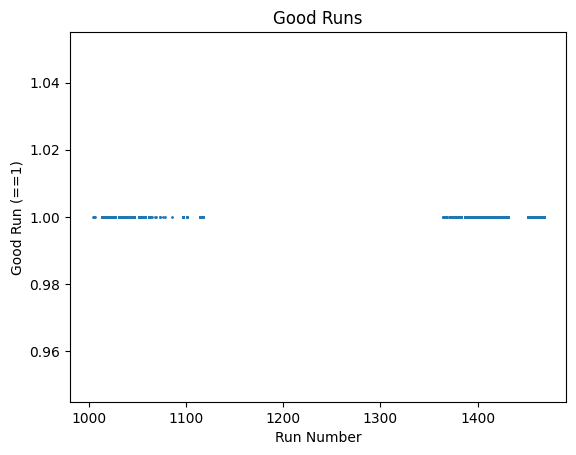

In [61]:
pltRuns = goodRuns[['run', 'goodRunTight']][goodRuns['goodRunTight']==True]
plt.scatter(pltRuns['run'], pltRuns['goodRunTight'], s=1)
plt.xlabel('Run Number')
plt.ylabel('Good Run (==1)')
plt.title("Good Runs")

In [163]:
lumis = pd.read_json('mqLumis.json', orient = 'split', compression = 'infer')
lumis


,run,file,lumis,fill,beam,beamInFill,dir,filename,start,stop,beamType,beamEnergy,betaStar,fillStart,fillEnd,startStableBeam,endStableBeam,lumiEst
0,1000,1,235.12358,8858,1.0,True,/store/user/milliqan/run3/bar//1000/0000,MilliQan_Run1000.1_default.root,2023-06-01T15:42:47.000Z,2023-06-01T15:43:14.000Z,PROTONS,6799.56,120.0,2023-06-01T11:12:18.000Z,2023-06-01T19:10:57.000Z,2023-06-01T13:07:00.000Z,2023-06-01T19:05:29.000Z,0.295148
1,1000,2,235.12358,8858,1.0,True,/store/user/milliqan/run3/bar//1000/0000,MilliQan_Run1000.2_default.root,2023-06-01T17:43:14.000Z,2023-06-01T17:43:42.000Z,PROTONS,6799.56,120.0,2023-06-01T11:12:18.000Z,2023-06-01T19:10:57.000Z,2023-06-01T13:07:00.000Z,2023-06-01T19:05:29.000Z,0.306079
2,1000,3,235.12358,8858,1.0,True,/store/user/milliqan/run3/bar//1000/0000,MilliQan_Run1000.3_default.root,2023-06-01T17:43:42.000Z,2023-06-01T17:44:06.000Z,PROTONS,6799.56,120.0,2023-06-01T11:12:18.000Z,2023-06-01T19:10:57.000Z,2023-06-01T13:07:00.000Z,2023-06-01T19:05:29.000Z,0.262354
3,1000,4,235.12358,8858,1.0,True,/store/user/milliqan/run3/bar//1000/0000,MilliQan_Run1000.4_default.root,2023-06-01T17:44:08.000Z,2023-06-01T17:44:32.000Z,PROTONS,6799.56,120.0,2023-06-01T11:12:18.000Z,2023-06-01T19:10:57.000Z,2023-06-01T13:07:00.000Z,2023-06-01T19:05:29.000Z,0.262354
4,1000,5,235.12358,8858,1.0,True,/store/user/milliqan/run3/bar//1000/0000,MilliQan_Run1000.5_default.root,2023-06-01T17:44:33.000Z,2023-06-01T17:44:57.000Z,PROTONS,6799.56,120.0,2023-06-01T11:12:18.000Z,2023-06-01T19:10:57.000Z,2023-06-01T13:07:00.000Z,2023-06-01T19:05:29.000Z,0.262354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69748,1602,112,0,None,0.0,False,/store/user/milliqan/run3/bar//1600/0000,MilliQan_Run1602.112_default.root,2024-05-31T18:33:12.000Z,2024-05-31T18:41:14.000Z,None,None,None,None,None,None,None,0.000000
69749,1602,113,0,None,0.0,False,/store/user/milliqan/run3/bar//1600/0000,MilliQan_Run1602.113_default.root,2024-05-31T18:41:15.000Z,2024-05-31T18:48:41.000Z,None,None,None,None,None,None,None,0.000000
69751,1602,120,0,None,0.0,False,/store/user/milliqan/run3/bar//1600/0000,MilliQan_Run1602.120_default.root,2024-05-31T19:34:16.000Z,2024-05-31T19:42:16.000Z,None,None,None,None,None,None,None,0.000000
69752,1602,121,0,None,0.0,False,/store/user/milliqan/run3/bar//1600/0000,MilliQan_Run1602.121_default.root,2024-05-31T19:42:16.000Z,2024-05-31T19:49:36.000Z,None,None,None,None,None,None,None,0.000000
